# Sentiment Analysis with Recurrent Neural Network

In this notebook report, we have trained a RNN model to analyze the sentiment in twitter dataset and predicted the sentiment of tweets in the test case.

In [1]:
# import libraries
import numpy as np
import pandas as pd
import re
import string
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns

# text preprocessing libraries
import string
from nltk.stem import WordNetLemmatizer
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords

# Text vectorization libraries
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# CNN libraries for text classification
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense
from keras.preprocessing.text import Tokenizer
from keras.layers import Dropout

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# path to the datasets for training and testing
trainData_path = '/content/drive/MyDrive/Twitter Dataset/train.csv'
testData_path = '/content/drive/MyDrive/Twitter Dataset/test.csv'

## Data Exploration

In [ ]:
# read the datasets into pandas dataframes
twitterDf = pd.read_csv(trainData_path)
twitterDf.head()

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation


In [ ]:
# check the shape of the dataframe
twitterDf.shape

(31962, 3)

The dataset contains three columns: `id`, `label`, and `tweet`. The `id` column is the unique identifier for each tweet. The `label` column is the sentiment label of the review. The `tweet` column contains the text of the tweet that is being analyzed. The sentiment label is either 0 (negative) or 1 (positive). The dataset contains 31962 rows and 3 columns.

In [ ]:
# check for null values
twitterDf.isnull().sum()

id       0
label    0
tweet    0
dtype: int64

In [ ]:
# counting the number of positive and negative tweets
twitterDf['label'].value_counts()

0    29720
1     2242
Name: label, dtype: int64

In [ ]:
 # map the labels 0 and 1 to positive and negative respectively
twitterDf['label'] = twitterDf['label'].map({0: 'Positive', 1: 'Negative'})

In [ ]:
twitterDf.sample(5)

,id,label,tweet
8963,8964,Positive,@user just bought tix for #victoria ! :)
15109,15110,Positive,3 years now in kannywood industry acting @us...
2065,2066,Positive,@user taking chances is liberating &amp; exci...
9784,9785,Positive,#model i love u take with u all the time in ...
6735,6736,Positive,! i walked 10353 today. #bhagmojobhag #nofail...


<Axes: >

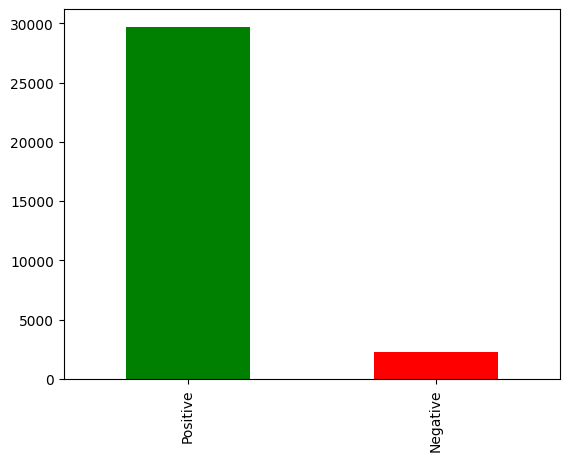

In [ ]:
# plotting the number of positive and negative tweets
twitterDf['label'].value_counts().plot(kind = 'bar', color = ['green', 'red'])

From the bar graph above it is clear that the dataset contains more positive tweets than negative tweets. The dataset is imbalanced. The dataset contains 29720 positive tweets and 2242 negative tweets.

In [ ]:
# adding a column to the dataframe to store the length of each tweet
twitterDf['tweet_length'] = twitterDf['tweet'].apply(lambda x:len(str(x).split()))

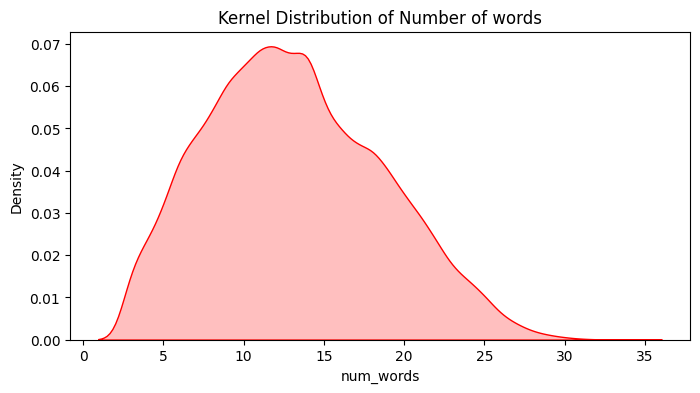

In [ ]:
# plotting the distribution of the number of words in each tweet

plt.figure(figsize=(8,4))
p1=sns.kdeplot(twitterDf['tweet_length'], fill=True, 
               color="r").set_title('Kernel Distribution of Number of words')


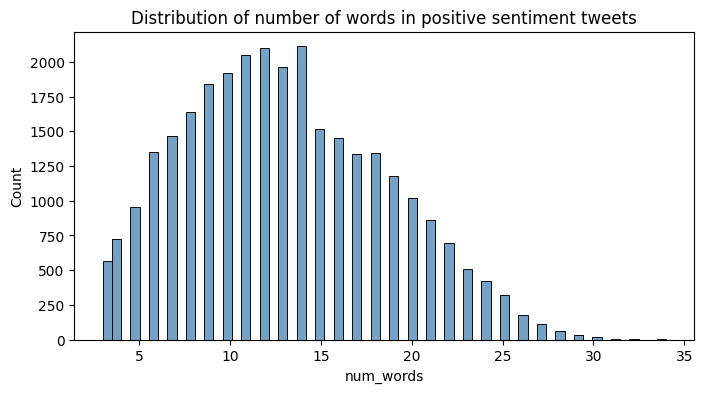

In [ ]:
# plotting the distribution of the number of words in each tweet for positive sentiment tweets

fig = plt.figure(figsize=(8,4))
sns.histplot(twitterDf[twitterDf['label']=='Positive']['tweet_length'], 
             color='steelblue').set_title('Distribution of number of words in positive sentiment tweets')

plt.show()

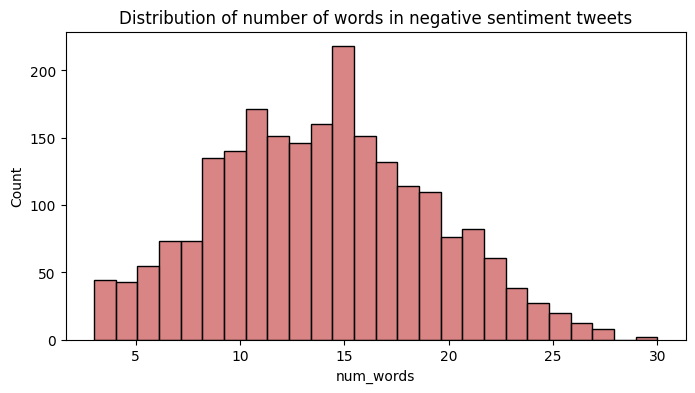

In [ ]:
#plotting the distribution of the number of words in each tweet for negative sentiment tweets

fig = plt.figure(figsize=(8,4))

sns.histplot(twitterDf[twitterDf['label']=='Negative']['tweet_length'],
             color='indianred').set_title('Distribution of number of words in negative sentiment tweets')

plt.show()

The number of words in each tweet ranges from 1 to 32. The average number of words in each tweet is 10. The maximum number of words in each tweet is 32. The minimum number of words in each tweet is 1.

In [ ]:
# removing the user mentions from the tweets using regular expressions

def removeMentions(text):
    return re.sub("@[A-Za-z0-9_]+", "", text)


twitterDf['tweet'] = twitterDf['tweet'].apply(lambda x: removeMentions(x))

In [ ]:
# counting the frequency of each word in the tweets and displaying the top 20 most frequent words

twitterDf['tweet_list'] = twitterDf['tweet'].apply(lambda x:str(x).split()) #convert tweets to list
top = Counter([item for sublist in twitterDf['tweet_list'] for item in sublist]) #count the frequency of each word in the tweets
temp = pd.DataFrame(top.most_common(20)) #create a dataframe of the top 20 most frequent words
temp.columns = ['Common_words','count']
temp

,Common_words,count
0,the,10066
1,to,9768
2,a,6261
3,i,5655
4,you,4949
5,and,4831
6,in,4570
7,for,4435
8,of,4152
9,is,4102


The most common word in the tweets is `the`. The second most common word in the tweets is `to`. The third most common word in the tweets is `a`. The fourth most common word in the tweets is `i`. The fifth most common word in the tweets is `you`.

## Data Preprocessing

In [4]:
# reading the dataset into a pandas dataframe again to start the preprocessing of the tweets
df_tweets = pd.read_csv(trainData_path)


Cleaning the tweets to remove the noise and unwanted characters. The following steps are performed:
- Removing Twitter Handles (@user), URLs, and Hashtags
- Removing Punctuations, Numbers, and Special Characters, removing emojis, and Converting to Lowercase
- Removing Short Words, double spaces, and Stopwords
- Lemmatization
- Tokenization


In [5]:
# change the tweet to lowerCase
def toLowerCase(text):
    return text.lower()

# remove special characters from the tweets 
def removeSpecialChars(text):
    return re.sub('[^a-zA-Z0-9\s]', '', text)

# removing the quotes from the tweets
def removeQuotes(text):
    return text.replace('"', '')

# remove the urls from the tweets
def removeURLS(text):
    return re.sub('http\S+|www.\S+', '', text, flags=re.IGNORECASE)

# remove the user mentions from the tweets
def removeMentions(text):
    return re.sub("@[A-Za-z0-9_]+", "", text)

# remove the hashtags from the tweets
def removeHashtags(text):
    return re.sub("#[A-Za-z0-9_]+", "", text)

# remove the punctuation from the tweets
def removePunctuations(text):
    special_characters = set(string.punctuation)
    return ''.join(char1 for char1 in text if char1 not in special_characters)

# remove the double spaces from the tweets
def removeDoubleSpace(text):
    return text.replace('  ', '')

# remove the emojis from the tweets
def removeEmojis(text):
    emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

# remove the stopwords from the tweets using the nltk library
def removeStopwords(text):
    stop = stopwords.words('english')
    return ' '.join([word for word in text.split() if word not in stop])

# remove the words with length less than 2 from the tweets
def removeShortWords(text):
    return ' '.join([w for w in text.split() if len(w) > 2])

# lemmatize the tweets using the nltk library
def lemmatizeText(text):
    lemmatizer = WordNetLemmatizer()
    return ' '.join([lemmatizer.lemmatize(word) for word in text.split()])


In [6]:
# preprocess the tweets using the functions defined above
def text_preprocessor(text):
    text = toLowerCase(text)
    text = removeSpecialChars(text)
    text = removeQuotes(text)
    text = removeURLS(text)
    text = removeMentions(text)
    text = removeHashtags(text)
    text = removePunctuations(text)
    text = removeDoubleSpace(text)
    text = removeEmojis(text)
    text = removeStopwords(text)
    text = removeShortWords(text)
    text = lemmatizeText(text)
    return text

In [7]:
# apply the preprocessing functions to the tweets and store the cleaned tweets in a new column

df_tweets['tweet_cleaned'] = df_tweets['tweet'].apply(text_preprocessor)
df_tweets.sample(5)

,id,label,tweet,tweet_cleaned
13840,13841,0,@user bihday haryana clpleader,user bihday haryana clpleader
14980,14981,0,friends on netflix!! ð,friend netflix
7320,7321,0,i am thankful for health. #thankful #positive ...,thankful health thankful positive
12303,12304,0,what a #view #oregon #poland #usa #unitedsta...,view oregon poland usa unitedstates holiday pr...
16461,16462,0,"@user the ""forever tropical #paradise"" #massw...",user forever tropical paradise masswedding cer...


Adding the cleaned tweets to a new column called `tweet_cleaned`. The `tweet_cleaned` column contains the cleaned tweets. Then adding start and end tokens to the tweets to distinguish the start and end of the tweet. The `tweet_cleaned` column contains the cleaned tweets with start and end tokens.

In [8]:
# function to add the start and end tokens to the tweets

def addStartEndToken(tweets):
    result = []
    for tweet in tweets:
        result.append('<start> ' + tweet + ' <end>')
    return result


In [9]:
# adding the start and end tokens to the cleaned tweets

df_tweets['tweet_cleaned']= addStartEndToken(df_tweets['tweet_cleaned'])
df_tweets.sample(5)

,id,label,tweet,tweet_cleaned
2441,2442,0,@user i am very disappointed after watching 10...,<start> user disappointed watching min episode...
29340,29341,0,i swear it feels like these strap-on &amp; dil...,<start> swear feel like strapon amp dildo gonn...
2911,2912,0,finally the hour count down til we leave to vi...,<start> finally hour count til leave victoria ...
31848,31849,0,top 10 food items a seasonal affective disor...,<start> top food item seasonal affective disor...
19871,19872,0,the view from my window. seriously #wow #trav...,<start> view window seriously wowtravel barcel...


Creating a vocabulary of all the words in the tweets. The vocabulary contains **45726** words. The vocabulary contains all the words in the tweets. The length of the vocabulary is used to create the embedding layer in the model.

In [10]:
# creating a vocabulary of all the words in the cleaned tweets
def createVocabulary(tweets):
    vocabulary = set()
    for tweet in tweets:
        for word in tweet.split():
            vocabulary.add(word)
    return vocabulary

# creating the vocabulary
vocabulary = createVocabulary(df_tweets['tweet_cleaned'])

In [11]:
# shuffle the dataframe to randomize the order of the tweets

df_tweets = df_tweets.sample(frac=1).reset_index(drop=True)
df_tweets.sample(5)

,id,label,tweet,tweet_cleaned
18197,5515,0,"cross check day passed! next week, on to resp...",<start> cross check day passednext week respon...
29291,26541,0,@user @user rip to one of the most amazing voi...,<start> user user rip one amazing voice talent...
30913,14519,0,@user i can not see you l'm feel sad #jai,<start> user see feel sad jai <end>
19136,30641,0,#bihday #later for my #lovely sis #love #cho...,<start> bihday later lovely si love chocolate ...
15455,941,0,so we rescued a pup... meet rexy ð¶â¡ #resc...,<start> rescued pup meet rexyrescuepup rexy pu...


In [12]:
# function to find the maximum length of the tweets in the dataframe

def maxTweetLength(tweets):
    return max(len(tweet.split()) for tweet in tweets)



In [13]:
maxTrainLength = maxTweetLength(df_tweets['tweet_cleaned']) # find the maximum length of the tweets in the dataframe

print("Max length of tweet: ", maxTrainLength)

Max length of tweet:  23


### Tokenization and Padding
- Tokenization: Tokenization is essential for RNNs to understand text as it converts raw text data into a numerical format that can be processed by the model. By tokenizing the text, we can represent each word or subword as a unique integer, which can be used to create a vector representation of the text.

- Padding: Padding is the process of adding zeros to the end of sequences so that they all have the same length. Padding ensures that the input sequences are of a same size, which is necessary for efficient computation and to avoid errors during the training process.

In [14]:
# function to tokenize the text data and pad the sequences to make them of the same length

def tokenizeText(df_tweets, maxTrainLength):
  
    # Create a tokenizer
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(df_tweets['tweet_cleaned']) # fit the tokenizer on the text data

    # Convert text to sequence of tokens
    X = tokenizer.texts_to_sequences(df_tweets['tweet_cleaned'])

    # padding the sequences to make them of the same length
    X = pad_sequences(X, maxlen=maxTrainLength, padding='post')
    
    return X


In [15]:
# tokenize the text data and pad the sequences to make them of the same length and store the result in X
X = tokenizeText(df_tweets, maxTrainLength)
X

array([[    2,    54,  3203, ...,     0,     0,     0],
       [    2,    35,   156, ...,     0,     0,     0],
       [    2,     3,     3, ...,     0,     0,     0],
       ...,
       [    2,    53,   509, ...,     0,     0,     0],
       [    2, 45724,    18, ...,     0,     0,     0],
       [    2,    40,   823, ...,     0,     0,     0]], dtype=int32)

In [30]:
# target variable for the model is the label column
y = df_tweets['label'].values

In [31]:
# converting the target variable to categorical values using one-hot encoding technique from the keras library

from keras.utils import to_categorical
y = to_categorical(y)
y

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       ...,
       [1., 0.],
       [1., 0.],
       [1., 0.]], dtype=float32)

## Building the Model

In [32]:
#splitting the data into training and testing sets with 80% of the data for training and 20% for testing

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size =0.2, random_state = 42)


The RNN model defined here has the following layers:

- An `Embedding` layer with `len(vocabulary)` number of nodes, where each word is represented as a 256-dimensional dense vector. The input length of the sequences is set to `maxTrainLength` and zeros are masked.

- A `LSTM` layer with 256 units, which allows the model to remember information from previous timesteps.

- A `Dropout` layer with a rate of 0.2, which helps prevent overfitting by randomly dropping out 50% of the input units.

- A `Dense` layer with 2 units and a `softmax` activation function, which outputs a probability distribution over the two classes. 


In [37]:
# creating the model using the keras sequential API

model = Sequential()
model.add(Embedding(len(vocabulary), 256, input_length=maxTrainLength,
                    mask_zero=True))
model.add(LSTM(256))
model.add(Dropout(0.2))
model.add(Dense(2, activation='softmax'))

In [38]:
#calculate class weights to handle the class imbalance in the dataset

from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight(class_weight = "balanced",
                                        classes = np.unique(df_tweets['label']),
                                        y = df_tweets['label'])
 
#convert the class weights to a dictionary
class_weights_dict = dict(enumerate(class_weights))

 

The above code is used to compile a neural network model using the categorical cross-entropy loss function, Adam optimizer, and three evaluation metrics: accuracy, precision, and recall.

- `loss='categorical_crossentropy'`: The categorical cross-entropy loss function is commonly used for multi-class classification problems.
- `optimizer='adam'`: Adam is an optimization algorithm that is commonly used for training neural network models.
- `metrics=['accuracy', Precision(), Recall()]`:
    - `accuracy`: This metric measures the percentage of correctly classified samples.
    - `Precision()`: This metric measures the fraction of true positives among all predicted positive samples. 
    - `Recall()`: This metric measures the fraction of true positives among all actual positive samples.


In [39]:
from keras.metrics import Precision, Recall

# compiling the model

model.compile(loss='categorical_crossentropy', optimizer='adam',
              metrics=['accuracy',Precision(),Recall()])



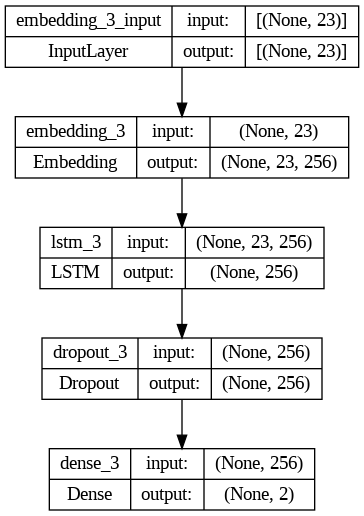

In [40]:
#visualize the model 
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, 
           show_layer_names=True)

In [41]:
# shape of the training and testing sets
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((25569, 23), (25569, 2), (6393, 23), (6393, 2))

## Model Training

In [42]:
# training the model for 3 epochs with a batch size of 32 and a validation split of 10%

history = model.fit(X_train, y_train, batch_size=32, 
                    epochs=5, validation_split=0.1,class_weight=class_weights_dict)


Epoch 1/5
720/720 [==============================] - 363s 422ms/step - loss: 0.3948 - accuracy: 0.8385 - precision_3: 0.8385 - recall_3: 0.8385 - val_loss: 0.3028 - val_accuracy: 0.8815 - val_precision_3: 0.8815 - val_recall_3: 0.8815
Epoch 2/5
720/720 [==============================] - 302s 419ms/step - loss: 0.0873 - accuracy: 0.9701 - precision_3: 0.9701 - recall_3: 0.9701 - val_loss: 0.2613 - val_accuracy: 0.9175 - val_precision_3: 0.9175 - val_recall_3: 0.9175
Epoch 3/5
720/720 [==============================] - 302s 419ms/step - loss: 0.0272 - accuracy: 0.9906 - precision_3: 0.9906 - recall_3: 0.9906 - val_loss: 0.3257 - val_accuracy: 0.8862 - val_precision_3: 0.8862 - val_recall_3: 0.8862
Epoch 4/5
720/720 [==============================] - 303s 421ms/step - loss: 0.0195 - accuracy: 0.9937 - precision_3: 0.9937 - recall_3: 0.9937 - val_loss: 0.2579 - val_accuracy: 0.9323 - val_precision_3: 0.9323 - val_recall_3: 0.9323
Epoch 5/5
720/720 [==============================] - 304s 42

## Model Evaluation

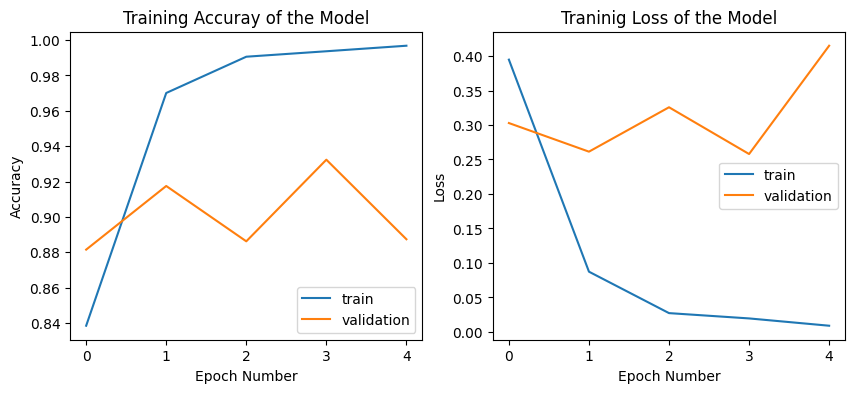

In [43]:
# plotting the training and validation accuracy and loss for each epoch

def plot_accuracy_loss(history):
    
    fig, ax = plt.subplots(1, 2, figsize=(10,4))
    # accuracy plot
    ax[0].plot(history.history['accuracy'])
    ax[0].plot(history.history['val_accuracy'])
    ax[0].set_title('Training Accuray of the Model')
    ax[0].set_xlabel('Epoch Number')
    ax[0].set_ylabel('Accuracy')
    ax[0].legend(['train', 'validation'], loc='best')
    
    # loss plot 
    ax[1].plot(history.history['loss'])
    ax[1].plot(history.history['val_loss'])
    ax[1].set_title('Traninig Loss of the Model')
    ax[1].set_xlabel('Epoch Number')
    ax[1].set_ylabel('Loss')
    ax[1].legend(['train', 'validation'], loc='best')
    
plot_accuracy_loss(history) # plot the accuracy and loss for the model

In [ ]:
# evaluate the model on the test set
model.evaluate(X_test, y_test, verbose=1)


200/200 [==============================] - 4s 21ms/step - loss: 0.2411 - accuracy: 0.9540 - precision: 0.9540 - recall: 0.9540


[0.2410598248243332,
 0.9540122151374817,
 0.9540122151374817,
 0.9540122151374817]

The evaluation on the test set shows that the model has an accuracy of 0.95, precision of 0.95, and recall of 0.95. The model performs well on the test set.

In [ ]:
# calculate the confusion matrix for the model on the test set

from sklearn.metrics import confusion_matrix
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)

y_actual = np.argmax(y_test, axis=1)

cm = confusion_matrix(y_actual, y_pred)
cm

200/200 [==============================] - 48s 175ms/step


array([[5846,   77],
       [ 206,  264]], dtype=int64)

### Confusion Matrix

#### Understanding True Positive, True Negative, False Positive and False Negative in a Confusion Matrix
True Positive (TP): The actual value was positive and the model predicted a positive value<br>
True Negative (TN): The actual value was negative and the model predicted a negative value<br>
False Positive (FP): The actual value was negative but the model predicted a positive value<br>
False Negative (FN): The actual value was positive but the model predicted a negative value<br><br>
In confusion matrix of sklearn,<br>
top left element = true negative<br>
bottom left element = false negative<br>
top right element = false positive<br>
bottom right element = true positive<br>

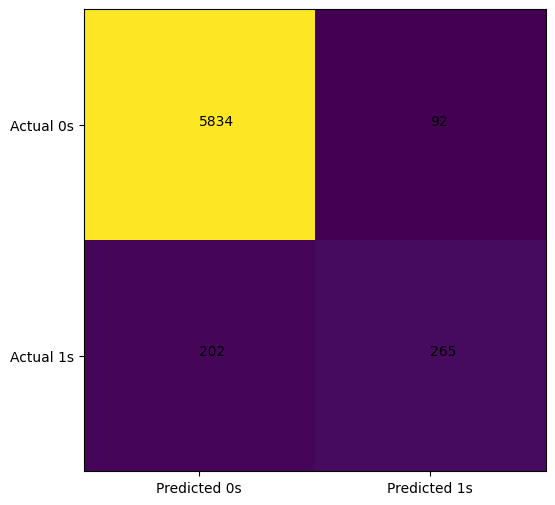

In [ ]:
# plot the confusion matrix

fig, axis = plt.subplots(figsize=(6, 6)) # creating a subplot for our figure, axis contains the heatmap
axis.imshow(cm)
axis.xaxis.set(ticks=(0, 1), ticklabels=('Predicted 0s', 'Predicted 1s')) # labeling the figure
axis.yaxis.set(ticks=(0, 1), ticklabels=('Actual 0s', 'Actual 1s'))

for i in range(2):
    for j in range(2):
        axis.text(j, i, cm[i, j]) 
plt.show()

**Accuracy**: It is the ratio of correctly predicted observations to the total observations. Accuracy = (TP + TN) / (TP + FP + FN + TP) <br>
**Precision**: It is the ratio of correctly predicted positive observations to the total predicted positive observations. Precision = TP / (TP + FP) <br>
**Recall**(Sensitivity): It is the ratio of correctly predicted positive observations to the actual no. of positive observations. Recall = TP / (TP + FN)<br>
**F1 Score**: It is the weighted average of Precision and Recall. F1 Score = 2*(Precison * Recall) / (Precision + Recall)

In [ ]:
# printing the accuracy, precision, recall, f1 score of the model
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

#print the accuracy,precision, recall and f1 score of this model
print("Test Set Accuracy:", accuracy_score(y_actual,y_pred))
print("Test Set Precision:", precision_score(y_actual, y_pred, ))
print("Test Set Recall:", recall_score(y_actual,y_pred))
print("Test Set F1 Score:", f1_score(y_actual,y_pred))

Test Set Accuracy: 0.9557328327858595
Test Set Precision: 0.7741935483870968
Test Set Recall: 0.5617021276595745
Test Set F1 Score: 0.6510480887792848


### AUC-ROC Curve
AUC-ROC curve is the process of calculating the Area Under The Curve (AUC) of Receiver Operating Characteristic (ROC)<br><br>
**The Receiver Operating Characteristic(ROC)** is a evaluation tool for binary classification that plots the true positive rate against the false positive rate, where TPR is on the y-axis and FPR is on the x-axis. <br>
In ROC curve, if the x-axis value is high then it indicates a higher number of False positive than True negative. Higher y-axis value indicates a higher number of true positive than false negative.<br><br>
**The Area Under the Curve(AUC)** is the measure of the ability of the model to distinguish between negative and positive classes.<br>
Higher the AUC, the better the model is at predicting 0 classes as 0 and 1 classes as 1.<br>
When AUC = 1, the model is able to perfectly distinguish between all the positive and negative classes.<br>
If, AUC = 0 then the model would predict all negative classes as positive and vice-versa.<br>
When AUC = 0.5 then the classifier model is said to be worthless as it will not be able to distinguish between positive and negative class. 


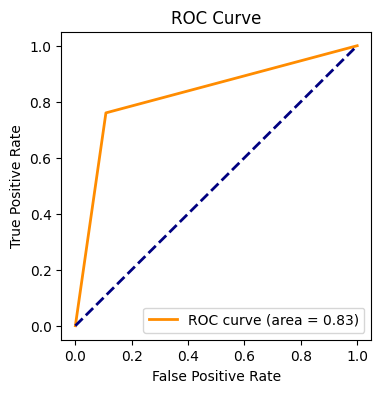

In [45]:
#plot  the ROC curve for the model
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(y_actual, y_pred)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(4,4))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0,1], [0,1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()
 

## Sentiment Prediction

In [46]:
# reading the test case dataset into a pandas dataframe
df_test = pd.read_csv(testData_path)
df_test.sample(5)


,id,tweet
12872,44835,it's killing me that #richardiii is sold out a...
8217,40180,it's the hardest to accept when things you tri...
2477,34440,@user we came all the way from ð©ðª to ð...
794,32757,@user me &amp; @user just ate at wasabi and m...
2966,34929,kissy faceðððð haven't seen this b...


In [47]:
# cleaning the tweets in the test dataset and adding the start and end tokens to the cleaned tweets

df_test['tweet_cleaned'] = df_test['tweet'].apply(text_preprocessor)
df_test['tweet_cleaned']= addStartEndToken(df_test['tweet_cleaned'])
df_test.sample(5)

,id,tweet,tweet_cleaned
3168,35131,@user @user today for #injectablesclinic #bot...,<start> user user today injectablesclinic boto...
324,32287,thank you so much @user i really am and feel...,<start> thank much user really feel amazing <end>
13810,45773,biggest #war is ever against #illiteracy (and...,<start> biggest war ever illiteracyand therefo...
8456,40419,@user tonight my last time with them... #veron...,<start> user tonight last time verona blacksab...
13909,45872,i am safe. #i_am #positive #affirmation,<start> safe iam positive affirmation <end>


In [48]:
maxTestLength = maxTweetLength(df_test['tweet_cleaned'])

X_testCase = tokenizeText(df_test, maxTestLength) # tokenize the text data and pad the sequences to make them of the same length

In [ ]:
# shape of the test case
X_testCase.shape

(17197, 23)

Predicting the sentiment of the tweets in the test case using the trained model

In [49]:
# predicting the sentiment of the tweets in the test case dataset

y_predTestCase = model.predict(X_testCase).argmax(axis=1)

538/538 [==============================] - 29s 54ms/step


Creating a dataframe to store the predicted sentiment of the tweets in the test case. The dataframe contains the `tweet_cleaned`,`tweet` and `sentiment` columns. The `tweet_cleaned` column contains the cleaned tweets. The `tweet` column contains the original tweets. The `sentiment` column contains the predicted sentiment of the tweets.

In [50]:
# create a dataframe with the tweet, sentiment and uncleaned text columns
df_pred = pd.DataFrame({'tweet_cleaned': df_test['tweet_cleaned'], 'tweet':df_test['tweet'],'sentiment': y_predTestCase})

In [51]:
# counting the number of positive and negative tweets predicted by the model
df_pred['sentiment'].value_counts()

0    15540
1     1657
Name: sentiment, dtype: int64

Model predicted 15540 tweets to be positive and 1657 to be negative out of 17197 tweets in the test case.

In [52]:
# printing a sample of negative tweets predicted by the model
df_pred[df_pred['sentiment'] == 1].sample(10)

,tweet_cleaned,tweet,sentiment
3826,<start> work fun tbt donjulio tequila diageo p...,when work is fun ð #tbt #donjulio #tequila...,1
9774,<start> great job kylie <end>,great job kylie!,1
16359,<start> would user ruin good radar page <end>,why would @user ruin such a good radar page ? ...,1
11323,<start> user livelovesmile goodevening night l...,@user live love smile ... â¤ðð #good...,1
292,<start> 30000 arrest daily usover 160000 polic...,"over 30,000 arrests daily in us;over 160,000 p...",1
14043,<start> pudo itsisepuede copa100 <end>,si se pudo ððâ¤ they did it ... #sis...,1
9286,<start> rip christina gunviolence <end>,#rip christina #gunviolence,1
16141,<start> terrorism shelling blast one sadness20...,#terrorism #shelling #blasts and one more #s...,1
15089,<start> wishing happy weekend weekend roselove...,wishing you all a happy weekend weekend #ros...,1
8218,<start> beautifulsunday user user user user us...,it's a #beautifulsunday @user @user @user @use...,1


In [53]:
# map the labels to positive and negative in the dataframe
df_pred['sentiment'] = df_pred['sentiment'].map({0: 'Positive', 1: 'Negative'})

<Axes: >

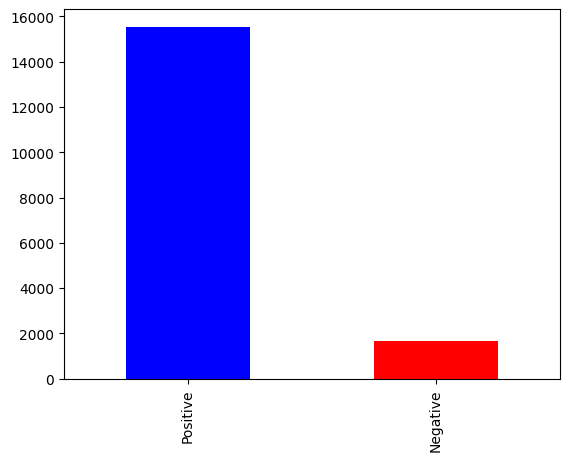

In [54]:
# visualize the sentiment distribution of the tweets in the test case dataset
df_pred['sentiment'].value_counts().plot(kind = 'bar', color = ['blue', 'red'])


## Results


The model has an accuracy of 0.95, precision of 0.95, and recall of 0.95. The model performs well on the test set. The model predicted 15540 tweets to be positive and 1657 to be negative out of 17197 tweets in the test case. Due to insufficient data and imbalance in the dataset, the model predicted more tweets to be positive than negative. The model can be improved by using more data and balancing the dataset.